# IMPORTS

In [1]:
# Imports
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import xgboost as xgb
import pandas as pd
import re
from tqdm import tqdm
from tabulate import tabulate
from scipy.stats import linregress,ttest_ind,ranksums
np.set_printoptions(suppress=True)
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

data_string = "../data/amsterdam/"

In [2]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)
    


# Function definitions

In [3]:
def ece_calculator(X,y,model,plot_bool=False,save_bool=False):
    confidences = np.max(model.predict_proba(X),axis=1)
    output_t = np.argmax(model.predict_proba(X),axis=1)

    max_bin = 5

    ECE_arr = np.array([])
    cal_plot_ECE = list([])
    ESCE_arr = np.array([])
    incre = 0.1

    for i in np.arange(0.5,max_bin + 0.1,incre):
        bins_size = i
        bin_epsilon = 0.00001
        bin_min = np.round(np.min(confidences*100))

        pred_out = output_t
        real_out = y.values
        bins_correct = plt.hist(confidences[np.where(pred_out==real_out)]*100,density=False,label="Correct pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')
        bins_incorrect = plt.hist(confidences[np.where(pred_out!=real_out)]*100,density=False,label="Incorrect pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')
        

        bin_means = np.array([])
        for b in np.arange(bin_min,101.0,bins_size):
            bin_means = np.append(bin_means,np.array(np.mean(np.append([bin_epsilon],confidences[np.where((confidences > b/100.0)&(confidences <= (b/100.0+bins_size/100.0)))]))))

        bin_means = bin_means[:-1]

        #avg accuracy per bin - avg confidence per bin (summed over all bins and normalized by width of size of bin)
        ECE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (np.abs(bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means)))
        cal_plot_ECE.append(np.array((bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon))))
        ESCE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means))
        ECE_arr = np.append(ECE_arr,np.array(ECE))
        ESCE_arr = np.append(ESCE_arr,np.array(ESCE))

    plt.clf()

    if plot_bool:
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(0.5,max_bin + 0.1,incre),ECE_arr*100,label="avg ECE")
        plt.plot(np.arange(0.5,max_bin + 0.1,incre),ESCE_arr*100,label="avg ESCE")

        plt.legend()
        plt.xlabel("Bin size ")
        plt.ylabel("ECE (% error)")
        plt.show()

        plt.figure(figsize=(8,4))

        bin_min = np.round(np.min(confidences*100))

        mean_sece = np.array([])
        increment_perc = 1
        for perc in np.arange(bin_min+increment_perc,100+increment_perc,increment_perc):
            mean_array = np.array([])
            idx = 0
            for calplots in cal_plot_ECE:
                bins_size = np.arange(0.5,max_bin + 0.1,incre)[idx]
                plot_arr = np.where(calplots!=0)

                x_ar = (np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2)[plot_arr]
                cal_plot_mean = calplots[plot_arr][np.where((x_ar < perc) & (x_ar >= perc-increment_perc))]
                
                if len(cal_plot_mean>0):
                    temp_mean = np.mean(cal_plot_mean)
                    mean_array = np.append(mean_array,temp_mean)
                
                idx += 1

            mean_sece = np.append(mean_sece,np.mean(mean_array))


        for i in range(len(cal_plot_ECE)):
            bins_size = np.arange(0.5,max_bin + 0.1,incre)[i]
            x_ar = np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2
            plot_arr = np.where(cal_plot_ECE[i]!=0)
            plt.plot(x_ar[plot_arr][:-1],cal_plot_ECE[i][plot_arr][:-1]*100,alpha=0.2,color="blue")
        plt.plot(np.arange(bin_min+increment_perc/2,100+increment_perc/2,increment_perc)[:-3],mean_sece[:-3]*100,color="red",label="Average")
        plt.plot([50,100],[50,100],color="black",label="Perfect calibration")
        plt.xlim([50,100])
        plt.ylim([0,100])
        plt.xticks(np.arange(50,104,5))
        plt.xlabel("Predicted probabilities (%)")
        plt.ylabel("Observed probabilities (%)")
        plt.grid()
        plt.legend()
        plt.savefig("../results/figures/calibration_plot.pdf")
        plt.savefig("../results/figures/calibration_plot.png")

        plt.show()

    print("ECE normalized AUC (%) = "+str(np.round(np.mean(ECE_arr)*100,2))+" %")
    print("ESCE normalized AUC (%) = "+str(np.round(np.mean(ESCE_arr)*100,2))+" %")

    return np.mean(ECE_arr),np.mean(ESCE_arr)

def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    ECE,ECSE = ece_calculator(X,y,model)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr),ECE,ECSE
                   ]],columns=amsterdam_result_dataframe_columns)])
    
    return append_df

# Data Import

In [4]:
amsterdam_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc","ECE","ECSE"]
amsterdam_result_dataframe = pd.DataFrame(columns=amsterdam_result_dataframe_columns)

In [23]:
#False
#True

one_half_hour_model = False
six_hour_model = True

model_string = ("1.5"*int(one_half_hour_model)+"12"*int(1-one_half_hour_model))*int(1-six_hour_model)+"6"*int(six_hour_model)
model_string

'6'

In [24]:
validation_type_string = "base model"

if one_half_hour_model:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_6_hours.csv") 
else:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_12_hours.csv") 

In [25]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

AF_dataset['is_given_Enoximon (Perfan)']=0
AF_dataset.loc[AF_dataset['mean_Enoximon (Perfan)']>0,'is_given_Enoximon (Perfan)']=1

AF_dataset.loc[AF_dataset['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

AF_dataset['is_given_Hydrocortison (Solu Cortef)']=0
AF_dataset.loc[AF_dataset['mean_Hydrocortison (Solu Cortef)']>0,'is_given_Hydrocortison (Solu Cortef)']=1

AF_dataset['is_given_Midazolam (Dormicum)']=0
AF_dataset.loc[AF_dataset['mean_Midazolam (Dormicum)']>0,'is_given_Midazolam (Dormicum)']=1

AF_dataset['is_given_Morfine']=0
AF_dataset.loc[AF_dataset['mean_Morfine']>0,'is_given_Morfine']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_Fentanyl']>0,'is_given_Fentanyl']=1

In [26]:
AF_dataset.loc[AF_dataset.Age==65,'Age'] = 69
AF_dataset.loc[AF_dataset.Age==35,'Age'] = 39
AF_dataset.loc[AF_dataset.Age==45,'Age'] = 49
AF_dataset.loc[AF_dataset.Age==55,'Age'] = 59
AF_dataset.loc[AF_dataset.Age==79,'Age'] = 79
AF_dataset.loc[AF_dataset.Age==85,'Age'] = 80

In [27]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [28]:
drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

In [29]:
X_train_or = train_AF_dataset[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

### Cross-Validation

In [71]:
cross_val_amsterdam_result_dataframe_columns = ["model","uzgent_removed","AUC","AUC std","MCC","MCC std","ACCURACY","ACCURACY std","F1","F1 std","PRECISION","PRECISION std","RECALL","RECALL std"]

def cross_vall_pandas_result_AF_maker(result_dict, normal, append_df):

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,normal,
                    Metrics_best["AUC"][0],Metrics_best["AUC"][1],
                    Metrics_best["MCC"][0],Metrics_best["MCC"][1],
                    Metrics_best["ACCURACY"][0],Metrics_best["ACCURACY"][1],
                    Metrics_best["F1"][0],Metrics_best["F1"][1],
                    Metrics_best["PRECISION"][0],Metrics_best["PRECISION"][1],
                    Metrics_best["RECALL"][0],Metrics_best["RECALL"][1],
                   ]],columns=cross_val_amsterdam_result_dataframe_columns)])
    
    return append_df

# cross_val_amsterdam_result_dataframe = pd.DataFrame(columns=cross_val_amsterdam_result_dataframe_columns)

In [72]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


## This cross_validation is different from the standard cross validation
# Inp_db:pandas_DataFrame = input database (contains labels and features), should contain heroi2c numbers as IDs, previous concentrations
# Features:List = features to use
# Folds:int = amount of folds
# RS:int = Random state
# Output:dict = dictionary with the results of each fold
def escim_cross_validation(Model,Inp_db,folds,RS,features,verbose):
    patients_CV = Inp_db.patientid.unique()
    
    kf = KFold(n_splits=folds,shuffle=True,random_state=RS)
    
    scores_cv_train = {"AUC":np.array([]),
                 "MCC":np.array([]),      
                 "ACCURACY":np.array([]),
                 "RECALL":np.array([]),
                 "F1":np.array([]),
                 "PRECISION":np.array([])}
    
    scores_cv_test = {"AUC":np.array([]),
                    "MCC":np.array([]),
                     "ACCURACY":np.array([]),
                     "RECALL":np.array([]),
                     "F1":np.array([]),
                     "PRECISION":np.array([])}
    fold_idx = 0
    for patient_CV_train_idx, patient_CV_test_idx in kf.split(patients_CV):
        if verbose:
            print("\r Training folds: "+str(fold_idx+1)+"/"+str(folds),end="")
        fold_idx = fold_idx+1
        ## Split per patient (to avoid data leakage)
        X_CV_train = Inp_db[Inp_db.patientid.isin(patients_CV[patient_CV_train_idx])]
        X_CV_test = Inp_db[Inp_db.patientid.isin(patients_CV[patient_CV_test_idx])]
            
        ## Calculate the required labels
        target = "AF"
        
        Y_CV_train = X_CV_train[target].values
        Y_CV_test = X_CV_test[target].values
        
        ## Extract the required features
        X_CV_train_feat = X_CV_train[features]
        X_CV_test_feat = X_CV_test[features]
        
        Model.fit(X_CV_train_feat,Y_CV_train)
        Y_CV_predict_test = Model.predict(X_CV_test_feat)
        Y_CV_predict_train = Model.predict(X_CV_train_feat)
        
        ## Calculate the cross validation scores

        y_cv_train_pred = Model.predict_proba(X_CV_train_feat)[:,1]
        y_cv_test_pred = Model.predict_proba(X_CV_test_feat)[:,1]
        
        train_results = classification_report(Y_CV_train,Model.predict(X_CV_train_feat),output_dict=True)
        test_results = classification_report(Y_CV_test,Model.predict(X_CV_test_feat),output_dict=True)
        
        scores_cv_train["AUC"]=np.append(scores_cv_train["AUC"],roc_auc_score(Y_CV_train,y_cv_train_pred))
        scores_cv_test["AUC"]=np.append(scores_cv_test["AUC"],roc_auc_score(Y_CV_test,y_cv_test_pred))

        scores_cv_train["MCC"]=np.append(scores_cv_train["MCC"],matthews_corrcoef(Y_CV_train,Model.predict(X_CV_train_feat)))
        scores_cv_test["MCC"]=np.append(scores_cv_test["MCC"],matthews_corrcoef(Y_CV_test,Model.predict(X_CV_test_feat)))
        
        scores_cv_train["ACCURACY"]=np.append(scores_cv_train["ACCURACY"],train_results["accuracy"])
        scores_cv_test["ACCURACY"]=np.append(scores_cv_test["ACCURACY"],test_results["accuracy"])

        scores_cv_train["RECALL"]=np.append(scores_cv_train["RECALL"],train_results['weighted avg']['recall'])
        scores_cv_test["RECALL"]=np.append(scores_cv_test["RECALL"],test_results['weighted avg']['recall'])

        scores_cv_train["F1"]=np.append(scores_cv_train["F1"],train_results['weighted avg']['f1-score'])
        scores_cv_test["F1"]=np.append(scores_cv_test["F1"],test_results['weighted avg']['f1-score'])

        scores_cv_train["PRECISION"]=np.append(scores_cv_train["PRECISION"],train_results['weighted avg']['precision'])
        scores_cv_test["PRECISION"]=np.append(scores_cv_test["PRECISION"],test_results['weighted avg']['precision'])
        
    return scores_cv_train,scores_cv_test

def repeated_k_fold_cv_esicm(Model_,Inp_db_,folds_,RS_,features_,repeats_,verbose_):
    repeated_cv_test = {"AUC":[np.array([]),np.array([])],
                 "MCC":[np.array([]),np.array([])],
                 "ACCURACY":[np.array([]),np.array([])],
                 "RECALL":[np.array([]),np.array([])],
                 "F1":[np.array([]),np.array([])],
                 "PRECISION":[np.array([]),np.array([])]}
    
    repeated_cv_train = {"AUC":[np.array([]),np.array([])],
                 "MCC":[np.array([]),np.array([])],
                 "ACCURACY":[np.array([]),np.array([])],
                 "RECALL":[np.array([]),np.array([])],
                 "F1":[np.array([]),np.array([])],
                 "PRECISION":[np.array([]),np.array([])]}
    
    for i in range(repeats_):
        if verbose_:
            print("Repeat: "+str(i+1)+"/"+str(repeats_))

        train_sc,test_sc = escim_cross_validation(Model=Model_,Inp_db=Inp_db_,folds=folds_,RS=i+RS_,features=features_,verbose=verbose_)

        if verbose_:
            print("")

        for key in test_sc:
            repeated_cv_test[key][0]=np.append(repeated_cv_test[key][0],test_sc[key])
            repeated_cv_train[key][0]=np.append(repeated_cv_train[key][0],train_sc[key])
            
    for key in repeated_cv_test:
        repeated_cv_test[key]=[np.mean(repeated_cv_test[key][0]),1.96*np.std(repeated_cv_test[key][0])]
        repeated_cv_train[key]=[np.mean(repeated_cv_train[key][0]),1.96*np.std(repeated_cv_train[key][0])]
    
    return repeated_cv_train,repeated_cv_test

In [100]:
include_ghent_excl_features = True

if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']
    
    ghent_excluded_columns = [
       'mean_Kreatinine (bloed)', 
       'is_given_Enoximon (Perfan)',
       'fluidin',
       'mean_Anion-Gap (bloed)', 
       'max_O2 l/min', 
    ]

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

    ghent_excluded_columns = [
        'max_APTT  (bloed)', 
        'is_given_Enoximon (Perfan)',
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

    ghent_excluded_columns = [
        'mean_O2 l/min',
        'is_given_Enoximon (Perfan)',
    ]


if include_ghent_excl_features:
    feature_cols_cv = feature_columns + ghent_excluded_columns
else:
    feature_cols_cv = feature_columns


METRIC = "AUC"
Metrics_best = {"AUC":[0,0],"MCC":[0,0],"ACCURACY":[0,0],"F1":[0,0],"PRECISION":[0,0],"RECALL":[0,0]}
parameter_best = {"depth":0,"learning_rate":0,"iterations":0,"l2reg":None,"Random_strength":0,"bagging_temp":0,"float_Feature":0}

dep_cv_arr = [1,2,3,4,5,6]
lr_cv_arr = [None]
its_cv_arr = [100,200,300,400,500]
l2reg_arr = [1,2,3,4,5,6]
rs_arr = [2]
loss_f = "Logloss"
random_strength_arr = [None]
bagging_temperature_arr = [None]
per_float_feature_quantization_arr=[None]

if one_half_hour_model:
    dep_cv_arr = [3]
    its_cv_arr = [300]
    l2reg_arr = [3]
elif six_hour_model:
    dep_cv_arr = [3]
    its_cv_arr = [400]
    l2reg_arr = [3]
else:
    dep_cv_arr = [3]
    its_cv_arr = [300]
    l2reg_arr = [3]



i_loop = 0
for dep_tune in dep_cv_arr:
    for lr_tune in lr_cv_arr:
        for it_tune in its_cv_arr:
            for l2_tune in l2reg_arr:
                for rand_strength in random_strength_arr: 
                    for bag_temp in bagging_temperature_arr:
                        for float_feat in per_float_feature_quantization_arr:
                            i_loop = i_loop + 1 
                            print("iteration "+str(i_loop)+"/"+str(len(dep_cv_arr)*len(lr_cv_arr)*len(its_cv_arr)*len(l2reg_arr)*len(random_strength_arr)*len(bagging_temperature_arr)*len(per_float_feature_quantization_arr)))
                            dep = dep_tune
                            lr = lr_tune
                            its = it_tune
                            l2reg = l2_tune
                            random_s = 2
                            rand_strength_s = rand_strength
                            bag_temp_s = bag_temp
                            float_feat_s = float_feat

                            AF_class_balance = [train_AF_dataset.AF.sum()/len(train_AF_dataset),1-train_AF_dataset.AF.sum()/len(train_AF_dataset)]

                            cv_model = CatBoostClassifier(verbose=False,
                                                            iterations=its,
                                                            learning_rate=lr,
                                                            depth=dep,
                                                            class_weights = AF_class_balance,
                                                            l2_leaf_reg=l2reg,
                                                            bagging_temperature = bag_temp_s,
                                                            per_float_feature_quantization = float_feat_s,
                                                            random_strength = rand_strength_s,
                                                            loss_function=loss_f,
                                                            random_seed=random_s)

                            metrics_results_train,metrics_results_test = repeated_k_fold_cv_esicm(Model_=cv_model,
                                                  Inp_db_=train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))],
                                                  folds_=10,
                                                  RS_=42,
                                                  features_=feature_cols_cv,
                                                  repeats_=2,verbose_=True)

                            print("The train metrics are: AUC : "+str(np.round(metrics_results_train["AUC"][0],4))+" ("+str(np.round(metrics_results_train["AUC"][1],4))+")"+
                                  " | MCC: "+str(np.round(metrics_results_train["MCC"][0],4))+" ("+str(np.round(metrics_results_train["MCC"][1],4))+")"+
                                  " | ACCURACY: "+str(np.round(metrics_results_train["ACCURACY"][0],4))+" ("+str(np.round(metrics_results_train["ACCURACY"][1],4))+")"+
                                  " | WEIGHTED F1: "+str(np.round(metrics_results_train["F1"][0],4))+" ("+str(np.round(metrics_results_train["F1"][1],4))+")"+
                                  " | WEIGHTED PRECISION: "+str(np.round(metrics_results_train["PRECISION"][0],4))+" ("+str(np.round(metrics_results_train["PRECISION"][1],4))+")"+
                                  " | WEIGHTED RECALL: "+str(np.round(metrics_results_train["RECALL"][0],4))+" ("+str(np.round(metrics_results_train["RECALL"][1],4))+")") 
                            print("The test metrics are: AUC : "+str(np.round(metrics_results_test["AUC"][0],4))+" ("+str(np.round(metrics_results_test["AUC"][1],4))+")"+
                                  " | MCC: "+str(np.round(metrics_results_test["MCC"][0],4))+" ("+str(np.round(metrics_results_test["MCC"][1],4))+")"+
                                  " | ACCURACY: "+str(np.round(metrics_results_test["ACCURACY"][0],4))+" ("+str(np.round(metrics_results_test["ACCURACY"][1],4))+")"+
                                  " | WEIGHTED F1: "+str(np.round(metrics_results_test["F1"][0],4))+" ("+str(np.round(metrics_results_test["F1"][1],4))+")"+
                                  " | WEIGHTED PRECISION: "+str(np.round(metrics_results_test["PRECISION"][0],4))+" ("+str(np.round(metrics_results_test["PRECISION"][1],4))+")"+
                                  " | WEIGHTED RECALL: "+str(np.round(metrics_results_test["RECALL"][0],4))+" ("+str(np.round(metrics_results_test["RECALL"][1],4))+")") 
                            print(50*"=")
                            if metrics_results_test[METRIC][0]>Metrics_best[METRIC][0]:
                                Metrics_best=metrics_results_test
                                parameter_best["depth"]=dep
                                parameter_best["learning_rate"]=lr
                                parameter_best["iterations"]=its
                                parameter_best["l2reg"]=l2reg
                                parameter_best["Random_strength"]=rand_strength_s
                                parameter_best["bagging_temp"]=bag_temp
                                parameter_best["float_Feature"]=float_feat

print(50*"=")                    
print("The test metrics are: AUC : "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
                      " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
                      " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
                      " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
                      " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
                      " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")") 
print(parameter_best)

cross_val_amsterdam_result_dataframe = cross_vall_pandas_result_AF_maker(Metrics_best, "without" if not include_ghent_excl_features else "included", cross_val_amsterdam_result_dataframe)

iteration 1/1
Repeat: 1/2
 Training folds: 10/10
Repeat: 2/2
 Training folds: 10/10
The train metrics are: AUC : 0.8381 (0.0052) | MCC: 0.5065 (0.0106) | ACCURACY: 0.7532 (0.0053) | WEIGHTED F1: 0.7532 (0.0053) | WEIGHTED PRECISION: 0.7533 (0.0053) | WEIGHTED RECALL: 0.7532 (0.0053)
The test metrics are: AUC : 0.7925 (0.0566) | MCC: 0.4344 (0.1142) | ACCURACY: 0.7167 (0.0567) | WEIGHTED F1: 0.7167 (0.0565) | WEIGHTED PRECISION: 0.7185 (0.0572) | WEIGHTED RECALL: 0.7167 (0.0567)
The test metrics are: AUC : 0.7925 (0.0566) | MCC: 0.4344 (0.1142) | ACCURACY: 0.7167 (0.0567) | WEIGHTED F1: 0.7167 (0.0565) | WEIGHTED PRECISION: 0.7185 (0.0572) | WEIGHTED RECALL: 0.7167 (0.0567)
{'depth': 3, 'learning_rate': None, 'iterations': 300, 'l2reg': 3, 'Random_strength': None, 'bagging_temp': None, 'float_Feature': None}


In [101]:
cross_val_amsterdam_result_dataframe.sort_values(["model","uzgent_removed"]).reset_index(drop=True)

,model,uzgent_removed,AUC,AUC std,MCC,MCC std,ACCURACY,ACCURACY std,F1,F1 std,PRECISION,PRECISION std,RECALL,RECALL std
0,1.5,included,0.807846,0.036962,0.454570,0.080884,0.727159,0.040534,0.727134,0.040480,0.728218,0.041460,0.727159,0.040534
1,1.5,without,0.804005,0.036953,0.456058,0.085699,0.727813,0.042778,0.727777,0.042792,0.729011,0.043853,0.727813,0.042778
2,12,included,0.792518,0.056577,0.434363,0.114214,0.716745,0.056727,0.716685,0.056533,0.718479,0.057171,0.716745,0.056727
3,12,without,0.793126,0.057108,0.433936,0.106371,0.716588,0.052727,0.716591,0.052704,0.718160,0.053647,0.716588,0.052727
4,6,included,0.786112,0.047987,0.420835,0.112781,0.710335,0.057148,0.710052,0.057744,0.711974,0.056339,0.710335,0.057148
5,6,without,0.785983,0.044710,0.428596,0.093591,0.713874,0.047613,0.713654,0.048080,0.715958,0.046946,0.713874,0.047613


In [102]:
# cross_val_amsterdam_result_dataframe.to_csv("../results/cross_val_results_with_features_with_without_uzgent_new.csv",index=False)

In [ ]:
## backwords FEATURE SELECTION code - !unused in manuscript!
features_to_select = ['Age', 'mean_O2 concentratie (Set)', 'mean_PEEP (Set)',
                        'max_CVD',  'max_UrineCAD',
                        'max_Fosfaat (bloed)', 
                        'is_given_Enoximon (Perfan)', 'mean_Lactaat (bloed)',
                        'max_Kreatinine (bloed)', 
                        'max_Hartfrequentie',
                        'is_given_Noradrenaline (Norepinefrine)',
                        'fluidout',  'max_Hb (bloed)', "mean_Thrombo's (bloed)",
                        'cardiac_surg_bool',
                        'mean_pH (bloed)', 'mean_O2-Saturatie (bloed)',
                        ]



CV_features_arr_final = ['Age']#,'mean_PEEP (Set)','max_Hartfrequentie']

Metric_changed = True

METRIC = "MCC"
Metrics_best = {"AUC":np.array([0,0]),
                "MCC":np.array([0,0]),
                 "ACCURACY":np.array([0,0]),
                 "RECALL":np.array([0,0]),
                 "F1":np.array([0,0]),
                 "PRECISION":np.array([0,0])}


#Forward feature selection method
while Metric_changed:
    print(60*"=")
    print("Iteration to select the "+str(len(CV_features_arr_final)+1)+"th feature.")
    
    #To keep the feature selection going
    Metric_changed = False
    
    feature_idx = 1
    for cv_feature in features_to_select:
        print("\r Feature "+str(feature_idx)+"/"+str(len(features_to_select)),end="")
        feature_idx = feature_idx + 1
        if cv_feature not in CV_features_arr_final:

            CV_features_current = CV_features_arr_final+[cv_feature]

            AF_class_balance = [train_AF_dataset.AF.sum()/len(train_AF_dataset),1-train_AF_dataset.AF.sum()/len(train_AF_dataset)]

            CB_AF = CatBoostClassifier(verbose=False,iterations=350,l2_leaf_reg=4,depth=4)           

            train_sc,test_sc = repeated_k_fold_cv_esicm(Model_=CB_AF,
                          Inp_db_=train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))],
                          folds_=10,
                          RS_=42,
                          features_=CV_features_current,#feature_columns,#train_AF_dataset.columns.drop(drop_columns),
                          repeats_=2,
                          verbose_=False)

            if test_sc[METRIC][0]>Metrics_best[METRIC][0]:
                Metrics_best=test_sc
                CV_features_current_best = CV_features_current
                Metric_changed = True
                
    print("\n")
    CV_features_arr_final = CV_features_current_best
    print("Current features: "+str(CV_features_arr_final))
    print("Status update: The current best metrics are AUC: "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
        " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
        " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
        " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
        " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
        " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")")

print(60*"=")
 
print("The test metrics are: AUC : "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
      " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
        " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
        " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
        " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
        " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")"+"\n with the features: "+str(CV_features_arr_final) ) 

### Powershap

In [27]:
from powershap import PowerShap

Inp_db = train_AF_dataset.copy(deep=True)

feature_cols = list(AF_dataset.columns.drop(drop_columns+["date_corresponds_to_AF_admid"]).values) #[x for x in causal_cols_CATE if not re.search("kurt|max|min|slope|causal|mean_Nor|date_corresponds",x)]#kurt|max|min|slope|causal|mean_Nor|date_corresponds",x)]
feature_cols = [x for x in feature_cols if not re.search("kurt|causal|date_corresponds",x)]


selector = PowerShap(
    model = CatBoostClassifier(verbose=0, n_estimators=400, depth=3, l2_leaf_reg=3, use_best_model=True),
    verbose=True,force_convergence=False,limit_convergence_its=1
)
selector.fit(Inp_db[feature_cols].reset_index(drop=True), Inp_db["AF"].values)

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.


  0%|          | 0/10 [00:00<?, ?it/s]

Automatic mode: powershap requires 25  iterations; The extra required iterations exceed the limit_automatic  threshold. Powershap will add  10 powershap iterations and  re-evaluate.


  0%|          | 0/10 [00:00<?, ?it/s]

Done!


PowerShap(limit_convergence_its=1,
          model=<catboost.core.CatBoostClassifier object at 0x000001765675E310>,
          verbose=True)

In [28]:
t = selector._processed_shaps_df
t[t.p_value<0.01].index.values

array(['Age', 'max_Hartfrequentie', 'urgency',
       'mean_O2 concentratie (Set)', 'mean_PEEP (Set)', 'min_CVD',
       'max_PEEP (Set)', 'slope_Hartfrequentie', 'mean_UrineCAD',
       'is_given_Noradrenaline (Norepinefrine)', 'mean_CVD',
       'mean_Hartfrequentie', 'mean_Noradrenaline (Norepinefrine)',
       'max_Noradrenaline (Norepinefrine)',
       'slope_Noradrenaline (Norepinefrine)', 'slope_ABP gemiddeld',
       'min_Noradrenaline (Norepinefrine)', 'mean_Furosemide (Lasix)',
       'max_ABP systolisch', 'mean_O2-Saturatie (bloed)', 'fluid_balance',
       'mean_ABP gemiddeld', 'max_UrineCAD', 'max_Enoximon (Perfan)',
       'mean_Enoximon (Perfan)', 'max_APTT  (bloed)',
       'min_Enoximon (Perfan)'], dtype=object)

In [29]:
selected_features = list(t[t.p_value<0.01].index.values)

final_features = {}
for feature in selected_features:
    splitted_string = feature.split('_')
    if len(splitted_string) == 1:
        final_features[feature] = feature
    elif splitted_string[0]=='is' and splitted_string[1]=='given':
        if not feature.split('_',2)[-1] in final_features.values():
            final_features[feature] = feature.split('_',2)[-1]
    else:
        if not feature.split('_',1)[-1] in final_features.values():
            final_features[feature] = feature.split('_',1)[-1]

list(final_features.keys())

['Age',
 'max_Hartfrequentie',
 'urgency',
 'mean_O2 concentratie (Set)',
 'mean_PEEP (Set)',
 'min_CVD',
 'mean_UrineCAD',
 'is_given_Noradrenaline (Norepinefrine)',
 'slope_ABP gemiddeld',
 'mean_Furosemide (Lasix)',
 'max_ABP systolisch',
 'mean_O2-Saturatie (bloed)',
 'fluid_balance',
 'max_Enoximon (Perfan)',
 'max_APTT  (bloed)']

## Testing

In [30]:
include_ghent_excl_features = False

if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']
    
    ghent_excluded_columns = [
       'mean_Kreatinine (bloed)', 
       'is_given_Enoximon (Perfan)',
       'fluidin',
       'mean_Anion-Gap (bloed)', 
       'max_O2 l/min', 
    ]

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

    ghent_excluded_columns = [
        'max_APTT  (bloed)', 
        'is_given_Enoximon (Perfan)',
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

    ghent_excluded_columns = [
        'mean_O2 l/min',
        'is_given_Enoximon (Perfan)',
    ]


if include_ghent_excl_features:
    feature_columns = feature_columns + ghent_excluded_columns

        
X_train=X_train_or[feature_columns]    
X_test= X_test_or[feature_columns] 

In [45]:
AF_class_balance = [y_train.sum()/len(y_train), 1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)


CB_AF.fit(X_train, y_train, eval_set=(X_test, y_test))


0:	learn: 0.6867133	test: 0.6869807	best: 0.6869807 (0)	total: 1.56ms	remaining: 466ms
100:	learn: 0.5384726	test: 0.5436626	best: 0.5436626 (100)	total: 123ms	remaining: 242ms
200:	learn: 0.5151898	test: 0.5298816	best: 0.5298816 (200)	total: 235ms	remaining: 116ms
299:	learn: 0.5018014	test: 0.5272685	best: 0.5272685 (299)	total: 353ms	remaining: 0us

bestTest = 0.5272684645
bestIteration = 299



In [46]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.75      0.75      0.75      1600
          AF       0.75      0.75      0.75      1600

    accuracy                           0.75      3200
   macro avg       0.75      0.75      0.75      3200
weighted avg       0.75      0.75      0.75      3200



In [47]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

amsterdam_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,amsterdam_result_dataframe)

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.74      0.73       400
          AF       0.73      0.71      0.72       400

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



AUC = 0.8123
MCC = 0.4527
ECE normalized AUC (%) = 4.79 %
ESCE normalized AUC (%) = 2.49 %


<Figure size 432x288 with 0 Axes>

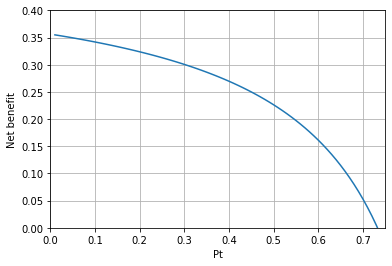

In [74]:
def net_benefit(Y,X,model,pt):
    return (np.sum(model.predict(X)[Y==1])-np.sum(model.predict(X)[Y==0])*(pt/(1.0-pt)))/len(Y)

plt.plot(np.arange(0.01,1.00,0.01),net_benefit(y_test,X_test,CB_AF,np.arange(0.01,1.00,0.01)))
plt.xlabel("Pt")
plt.ylabel("Net benefit")
plt.ylim([0,0.4])
plt.xlim([0,0.75])
plt.grid()

print(brier_score_loss(y_test,CB_AF.predict_proba(X_test)[:,1]))

<Figure size 432x288 with 0 Axes>

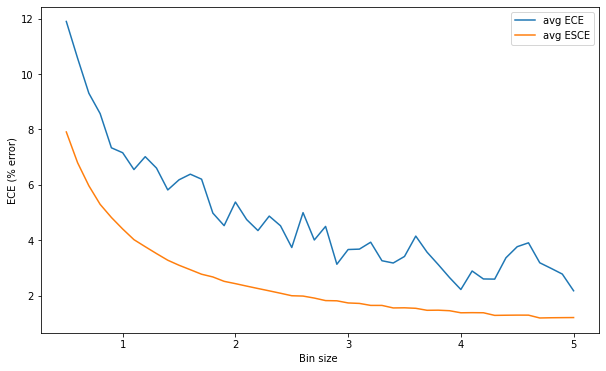

Mean of empty slice.
invalid value encountered in double_scalars


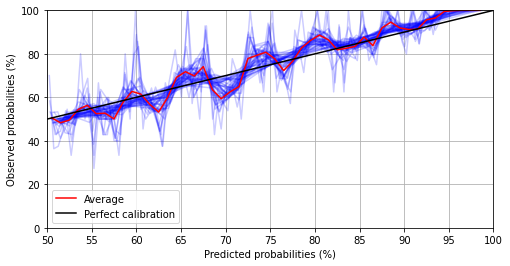

ECE normalized AUC (%) = 4.79 %
ESCE normalized AUC (%) = 2.49 %


(0.04794255781507535, 0.02492960334100067)

In [41]:
ece_calculator(X_test,y_test,CB_AF,plot_bool=True)

#### All testing

In [76]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_0_matched_df.patientid)))|(AF_dataset.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print("Brier score = " +str(np.round(brier_score_loss(y_test_all_pat,CB_AF.predict_proba(X_test_all_pat)[:,1]),4)))
print(50*"=")

amsterdam_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,amsterdam_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print("Brier score = " +str(np.round(brier_score_loss(y_test,CB_AF.predict_proba(X_test)[:,1]),4)))
print(50*"=")

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.75      0.85     14091
          AF       0.07      0.71      0.14       400

    accuracy                           0.75     14491
   macro avg       0.53      0.73      0.49     14491
weighted avg       0.96      0.75      0.83     14491



AUC = 0.8097
MCC = 0.1716
Brier score = 0.172
ECE normalized AUC (%) = 3.91 %
ESCE normalized AUC (%) = 3.85 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.74      0.73       400
          AF       0.73      0.71      0.72       400

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



AUC = 0.8123
MCC = 0.4527
Brier score = 0.177


<Figure size 432x288 with 0 Axes>

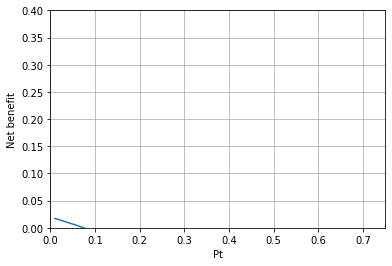

In [77]:
plt.plot(np.arange(0.01,1.00,0.01),net_benefit(y_test_all_pat,X_test_all_pat,CB_AF,np.arange(0.01,1.00,0.01)))
plt.xlabel("Pt")
plt.ylabel("Net benefit")
plt.ylim([0,0.4])
plt.xlim([0,0.75])
plt.grid()

<Figure size 432x288 with 0 Axes>

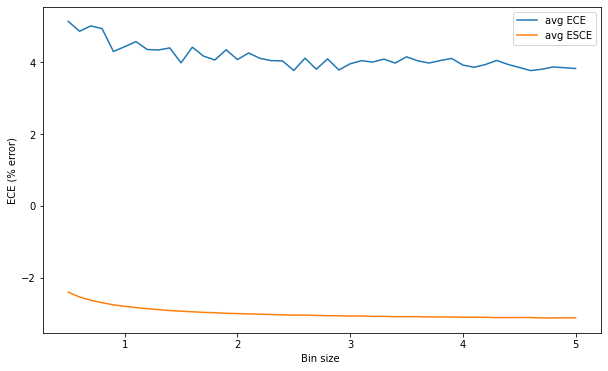

Mean of empty slice.
invalid value encountered in double_scalars


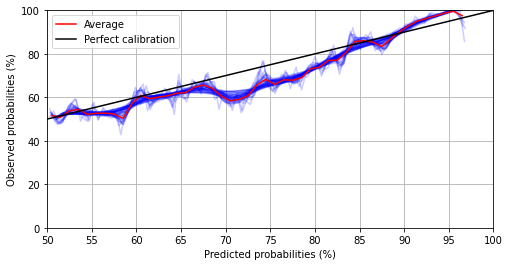

ECE normalized AUC (%) = 4.14 %
ESCE normalized AUC (%) = -2.99 %


(0.04142240468929484, -0.02991234227570603)

In [35]:
ece_calculator(X_test_all_pat,y_test_all_pat,CB_AF,plot_bool=True,save_bool=False)

In [45]:
amsterdam_result_dataframe.sort_values(["model","patient_group"])
# amsterdam_result_dataframe.sort_values(["model","patient_group"]).to_csv("../results/internal_amsterdam_result_dataframe.csv",index=False)

### Shap value visualization

In [16]:
rename_dict = {'mean_Lactaat (bloed)':'Mean lactate (mmol/L)',
'slope_Hartfrequentie':'Slope heart frequency (bpm)',
'max_Hartfrequentie':'Max heart frequency (bpm)',
'mean_UrineCAD':'Mean hourly urinary volume (mL/h)',
'min_UrineCAD':'Min hourly urinary volume (mL/h)',
'mean_O2-Saturatie (bloed)':'Mean calculated O2 saturation on ABG (%)',
'max_PO2 (bloed)':'Max ABG partial oxygen pressure (mm Hg)',
'mean_O2 concentratie (Set)':'Mean ventilator administered FiO2 (%)',
'urgency':'ICU admission Urgency',
"min_Thrombo's (bloed)":'Min thrombocytes (103/ \mu L)',
'is_given_Noradrenaline (Norepinefrine)':'Has received noradrenalin',
'min_Ureum (bloed)':'Min blood ureum (mmol/L)',
'mean_Ureum (bloed)':'Mean blood ureum (mmol/L)',
'is_given_Furosemide (Lasix)':'Has received loop diuretics',
'min_Act.HCO3 (bloed)':'Min bicarbonate (mmol/L',
'mean_Act.HCO3 (bloed)':'Mean bicarbonate (mmol/L',
'Weight':'Weight (kg)',
'mean_PEEP (Set)':'Mean PEEP setting (mm Hg)',
'fluid_balance':'Fluid Balance (mL)',
'mean_CVD':'Mean CVP (mm Hg)',
'min_CVD':'Min CVP (mm Hg)',
'max_CVD':'Man CVP (mm Hg)',
'slope_ABP systolisch':'Slope systolic arterial blood pressure (mm Hg)',
'min_ABP systolisch':'Min systolic arterial blood pressure (mm Hg)',
'min_pH (bloed)':'Min arterial pH on blood gas',
'slope_ABP gemiddeld':'Slope mean arterial blood pressure (mm Hg)',
'min_ABP gemiddeld':'Min mean arterial blood pressure (mm Hg)',
'slope_B.E. (bloed)':'Slope base excess (mmol/L)'}

X_test_renamed = X_test.rename(columns=rename_dict)

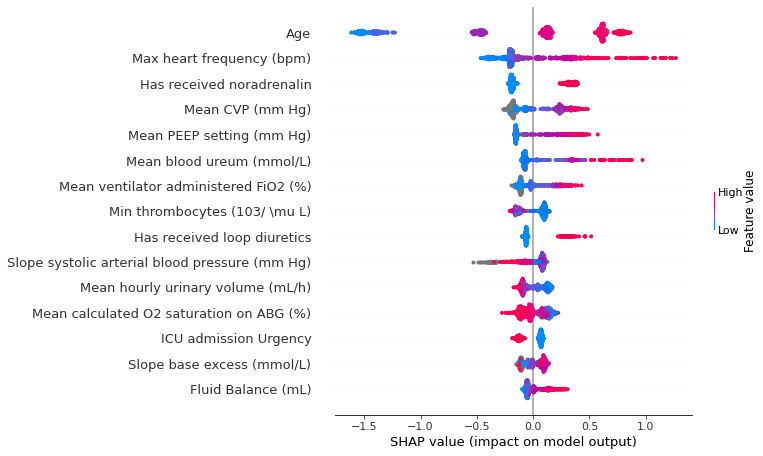

In [25]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(20,12))
shap.summary_plot(shap_values, X_test_renamed,show=False)

# plt.tight_layout()
plt.savefig("../results/figures/shap_1_5.pdf", bbox_inches = "tight")
plt.savefig("../results/figures/shap_1_5.png", bbox_inches = "tight")

### P-value calculation
Old code used for comparing the performances of the models. 

In [ ]:
if one_half_hour_model:
    #1,5
    y_test_1_5 = y_test
    predict_1_5 = CB_AF.predict(X_test)
    check_1_5 = 1

elif not six_hour_model:
    #6
    y_test_6 = y_test
    predict_6 = CB_AF.predict(X_test)
    check_6 = 1

else:
    #12
    y_test_12 = y_test
    predict_12 = CB_AF.predict(X_test)
    check_12 = 1


In [ ]:
# #bonferri correction: alpha/m, with m the amount of total tests
# from scipy.stats import ranksums

# internal_p_value_dataframe = pd.DataFrame(columns=["Comparison 1","Comparison 2","p_value"])

# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["1_5","6",ranksums(predict_1_5,predict_6)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))
# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["1_5","12",ranksums(predict_1_5,predict_12)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))
# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["6","12",ranksums(predict_6,predict_12)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))

# internal_p_value_dataframe.reset_index(drop=True).to_csv("../results/internal_p_value.csv",index=False)

## Risk over time visualization
To evaluatie this, run the Data Import section of AF data preparation. 

In [71]:
rename_dict = {'mean_Lactaat (bloed)':'Mean lactate (mmol/L)',
'slope_Hartfrequentie':'Slope heart frequency (bpm)',
'max_Hartfrequentie':'Max heart frequency (bpm)',
'mean_UrineCAD':'Mean hourly urinary volume (mL/h)',
'min_UrineCAD':'Min hourly urinary volume (mL/h)',
'mean_O2-Saturatie (bloed)':'Mean calculated O2 saturation on ABG (%)',
'max_PO2 (bloed)':'Max ABG partial oxygen pressure (mm Hg)',
'mean_O2 concentratie (Set)':'Mean ventilator administered FiO2 (%)',
'urgency':'ICU admission Urgency',
"min_Thrombo's (bloed)":'Min thrombocytes (103/ \mu L)',
'is_given_Noradrenaline (Norepinefrine)':'Has received noradrenalin',
'min_Ureum (bloed)':'Min blood ureum (mmol/L)',
'mean_Ureum (bloed)':'Mean blood ureum (mmol/L)',
'is_given_Furosemide (Lasix)':'Administration of loop diuretics',
'min_Act.HCO3 (bloed)':'Min bicarbonate (mmol/L',
'mean_Act.HCO3 (bloed)':'Mean bicarbonate (mmol/L',
'Weight':'Weight (kg)',
'mean_PEEP (Set)':'Mean PEEP setting (mm Hg)',
'fluid_balance':'Fluid Balance (mL)',
'mean_CVD':'Mean CVP (mm Hg)',
'min_CVD':'Min CVP (mm Hg)',
'max_CVD':'Man CVP (mm Hg)',
'slope_ABP systolisch':'Slope systolic arterial blood pressure (mm Hg)',
'min_ABP systolisch':'Min systolic arterial blood pressure (mm Hg)',
'min_pH (bloed)':'Min arterial pH on blood gas',
'slope_ABP gemiddeld':'Slope mean arterial blood pressure (mm Hg)',
'min_ABP gemiddeld':'Min mean arterial blood pressure (mm Hg)',
'slope_B.E. (bloed)':'Slope base excess (mmol/L)'}

In [124]:
include_ghent_excl_features = False

if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']
    
    ghent_excluded_columns = [
       'mean_Kreatinine (bloed)', 
       'is_given_Enoximon (Perfan)',
       'fluidin',
       'mean_Anion-Gap (bloed)', 
       'max_O2 l/min', 
    ]

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

    ghent_excluded_columns = [
        'max_APTT  (bloed)', 
        'max_Enoximon (Perfan)',
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

    ghent_excluded_columns = [
        'mean_O2 l/min',
        'max_Enoximon (Perfan)',
    ]

for index, data in enumerate(feature_columns):
    for key, value in rename_dict.items():
        if key in data:
            feature_columns[index]=data.replace(key, rename_dict[key])

X_train_or = X_train_or.rename(columns=rename_dict)
X_test_or = X_test_or.rename(columns=rename_dict)

X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

AF_class_balance = [y_train.sum()/len(y_train), 1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

explainer = shap.Explainer(CB_AF)


0:	learn: 0.6863123	total: 1.32ms	remaining: 395ms
100:	learn: 0.5396286	total: 121ms	remaining: 239ms
200:	learn: 0.5179496	total: 233ms	remaining: 115ms
299:	learn: 0.5048047	total: 342ms	remaining: 0us


### Patient level

4/100

Columns (660) have mixed types.Specify dtype option on import or set low_memory=False.


92/1007922    1
Name: AF_orig, dtype: int64
admissionid = 10309


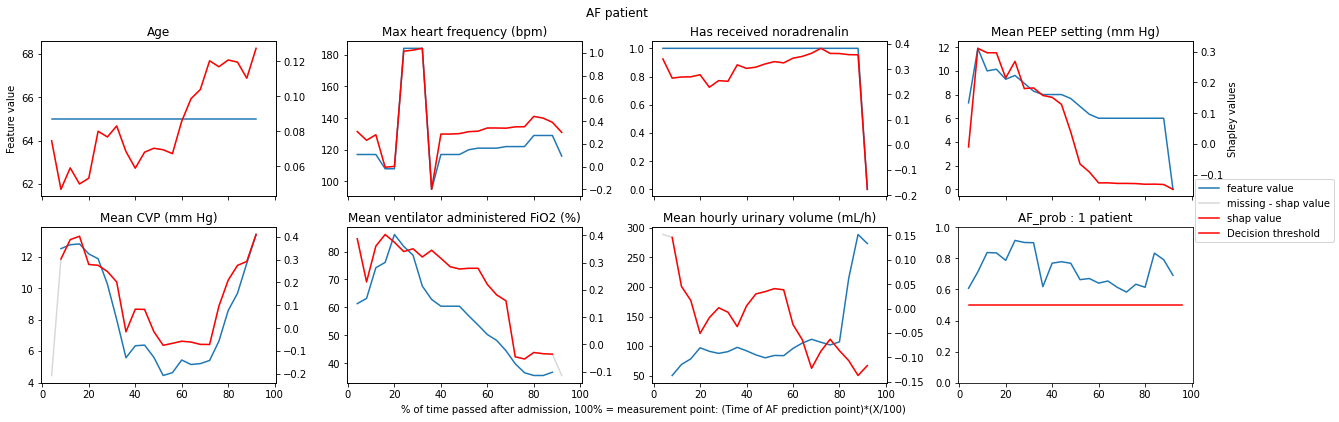

In [148]:
use_X_hours_after_admission = False #add absolute hours to admission time until the time exceeds or is equal to the prediction point
use_X_percentage_after_admission = True #make windows based on the percentage time already on ICU, with 100% the time to the prediction point, if false, substract absolute hours from measuredat

min_time_difference_to_AF = 96
if not use_X_hours_after_admission:
    if use_X_percentage_after_admission:
        if one_half_hour_model:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
        else:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
    else:
        if one_half_hour_model:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
        else:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
else:
    if one_half_hour_model:
        AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")
    else:
        AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")

random_state = 25

test_AF_false_dataset = AF_dataset_false[AF_dataset_false.admissionid.isin(test_admissionid)|(AF_dataset_false.date_corresponds_to_AF_admid.isin(test_admissionid))]
patient_admissionid = 10309 #test_AF_false_dataset.admissionid.sample(1).values[0]

start_for_arange = 4 #if only_data_of_first_hours else 4
end_for_arange = 96 #201

feat_change = {}
shap_change = {}

shap_values = explainer(X_test)
shap_df = pd.DataFrame(data=np.transpose(np.vstack([np.mean(np.abs(shap_values.values),axis=0),X_test.columns.values])),columns=["shap_values","column_name"])
rot_feature_columns = shap_df.sort_values("shap_values",ascending=False)["column_name"][:7].values

for feat in rot_feature_columns:
    feat_change[feat]=np.array([])
    shap_change[feat]=np.array([])

feat_change.update({"AF_prob":np.array([])})

drop_plot = np.array([])

for min_time_difference_to_AF in np.arange(start_for_arange,end_for_arange,4):
    print("\r"+str(min_time_difference_to_AF)+"/100",end="")
    
    if not use_X_hours_after_admission:
        if use_X_percentage_after_admission:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
            else:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
        else:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
            else:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
    else:
        if one_half_hour_model:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")
        else:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")

    AF_dataset_false["is_given_Magnesiumsulfaat (MgSO4)"]=0
    AF_dataset_false["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
    AF_dataset_false.loc[AF_dataset_false['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

    AF_dataset_false["is_given_LoopDiuretics"]=0
    if 'mean_Bumetanide (Burinex)' in AF_dataset_false.columns:
        AF_dataset_false.loc[(AF_dataset_false['mean_Bumetanide (Burinex)']>0) | (AF_dataset_false['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

    AF_dataset_false['is_given_Propofol (Diprivan)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

    AF_dataset_false['is_given_Dopamine (Inotropin)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

    AF_dataset_false.loc[AF_dataset_false['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

    AF_dataset_false = AF_dataset_false.rename(columns=rename_dict)


    test_AF_false_dataset = AF_dataset_false[(AF_dataset_false.admissionid.isin(test_admissionid))|(AF_dataset_false.date_corresponds_to_AF_admid.isin(test_admissionid))]
    test_AF_false_feature_df = test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][feature_columns]

    shap_values = explainer(pd.concat([X_train,test_AF_false_feature_df]))
    patient_shap_values = shap_values.values[-1]
    
    if patient_admissionid in test_AF_false_dataset.admissionid.values:
        test_AF_false_feature_df = test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][feature_columns]

        for key in feat_change.keys():
            if key == "AF_prob":
                feat_change[key] = np.append(feat_change[key],CB_AF.predict_proba(test_AF_false_feature_df)[:,1])
            else:
                # we need the index in the original feature column becuase the rot_Feature_column is shuffled
                shap_change[key] = np.append(shap_change[key],patient_shap_values[list(feature_columns).index(key)])
                feat_change[key] = np.append(feat_change[key],test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][key])
 
    else:
        print("")
        print("ERROR admissionid not found in the dataset")
        drop_plot = np.append(drop_plot,np.int(min_time_difference_to_AF/4)-1)
            
fig,axs = plt.subplots(int(np.ceil(len(feat_change)/4)),4,figsize=(20,6),sharex=True)

ax_blub_ar = np.array([])

i = 0
for key in feat_change.keys():
    
    if int(i/4)==0 and i%4 == 0:
        axs[int(i/4),i%4].set_ylabel("Feature value")
    
    if key == "AF_prob":
        axs[int(i/4),i%4].plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),feat_change[key])
        axs[int(i/4),i%4].plot([start_for_arange,end_for_arange],[0.5,0.5],color="red",label="Decision threshold")
        axs[int(i/4),i%4].set_title(key+ " : "+str(AF_dataset[AF_dataset.admissionid==patient_admissionid]["AF"].values[0])+" patient")
        axs[int(i/4),i%4].set_ylim([0,1])

    else:
        axs[int(i/4),i%4].plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),feat_change[key],label="feature value")
        ax_blub = axs[int(i/4),i%4].twinx()
        nan_shap_change = shap_change[key]*(feat_change[key]+0.00000001)/(feat_change[key]+0.00000001)
        ax_blub.plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),shap_change[key],color="gray",alpha=0.3,label="missing - shap value")
        ax_blub.plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),nan_shap_change,color="red",label="shap value")
        if i%4 == 3:
            ax_blub.set_ylabel("Shapley values")
        axs[int(i/4),i%4].set_title(key)
        ax_blub_ar = np.append(ax_blub_ar,ax_blub)

    i = i+1
    

fig.suptitle("NO AF patient" if test_AF_false_dataset[test_AF_false_dataset.admissionid == patient_admissionid].AF_orig.values[0]==0 else "AF patient")

handles, labels = [(a + b + c) for a, b, c in zip(axs[0,-1].get_legend_handles_labels(), ax_blub_ar[-1].get_legend_handles_labels(),axs[1,-1].get_legend_handles_labels())]

fig.legend(handles, labels, loc='center right')

plt.subplots_adjust(left=0.1,bottom=0.11,right=0.9,top=0.9,wspace=0.3,hspace=0.2)

if use_X_percentage_after_admission:
    fig.text(0.35, 0.04, "% of time passed after admission, 100% = measurement point: (Time of AF prediction point)*(X/100)")
else:
    if use_X_hours_after_admission:
        fig.text(0.5, 0.04, "Hours after admission: X", ha='center')
    else:
        fig.text(0.5, 0.04, "Hours subtracted from AF event: Time of AF prediction point-X", ha='center')

print(test_AF_false_dataset[test_AF_false_dataset.admissionid == patient_admissionid].AF_orig )
print("admissionid = "+str(patient_admissionid))

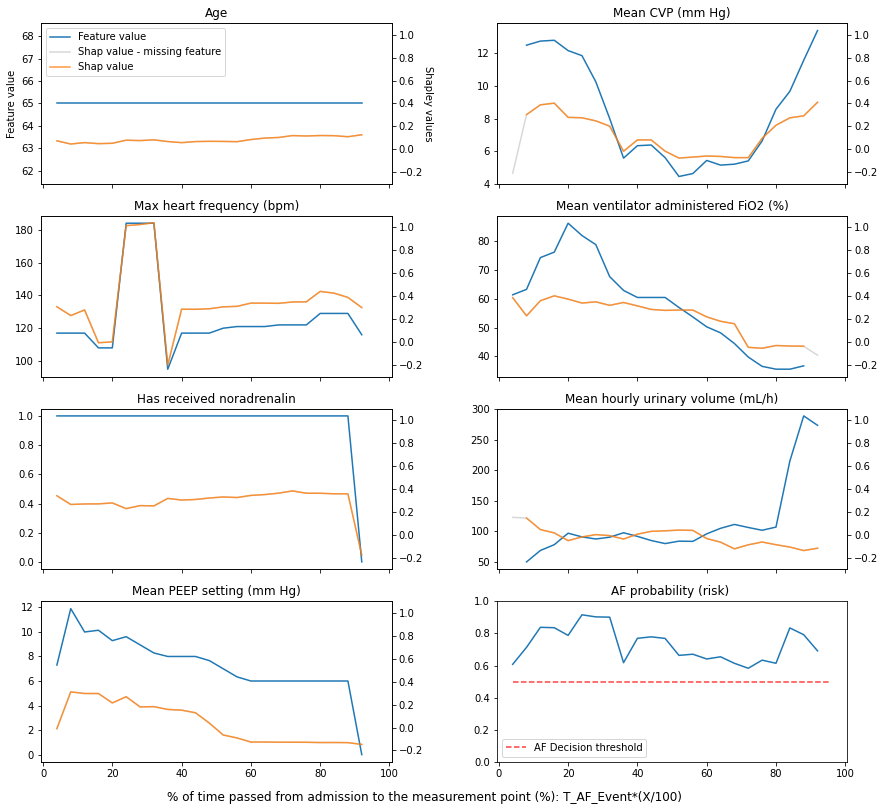

In [153]:
            
fig,axs = plt.subplots(4,int(np.ceil(len(feat_change)/4)),figsize=(14,12),sharex=True)

ax_blub_ar = np.array([])

i = 0
for key in feat_change.keys():
    
    if int(i/4)==0 and i%4 == 0:
        axs[i%4,int(i/4)].set_ylabel("Feature value")
    
    if key == "AF_prob":
        axs[i%4,int(i/4)].plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),feat_change[key])
        axs[i%4,int(i/4)].plot([start_for_arange,end_for_arange],[0.5,0.5],color="red",label="AF Decision threshold",linestyle='dashed',alpha=0.75)
        axs[i%4,int(i/4)].set_title("AF probability (risk) ")#+str(AF_dataset[AF_dataset.admissionid==patient_admissionid]["AF"].values[0])+" patient")
        axs[i%4,int(i/4)].set_ylim([0,1])
        axs[i%4,int(i/4)].legend(loc="lower left")

    else:
        axs[i%4,int(i/4)].plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),feat_change[key],color="C0",label="Feature value")
        ax_blub = axs[i%4,int(i/4)].twinx()
        nan_shap_change = shap_change[key]*(feat_change[key]+0.00000001)/(feat_change[key]+0.00000001)
        ax_blub.plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),shap_change[key],color="C7",alpha=0.3,label="Shap value - missing feature")
        ax_blub.plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),nan_shap_change,color="C1",alpha=0.8,label="Shap value")
        if int(i/4)==0 and i%4 == 0:
            ax_blub.set_ylabel("Shapley values",rotation=270,labelpad=10)
        ax_blub.set_ylim([-0.3,1.1])
        axs[i%4,int(i/4)].set_title(key)
        ax_blub_ar = np.append(ax_blub_ar,ax_blub)

    i = i+1
    

handles, labels = [(a + b) for a, b in zip(axs[0,-1].get_legend_handles_labels(), ax_blub_ar[-1].get_legend_handles_labels())]

axs[0,0].legend(handles, labels, loc='upper left')

plt.subplots_adjust(left=0.1,bottom=0.075,right=0.9,top=0.93,wspace=0.3,hspace=0.2)

if use_X_percentage_after_admission:
    fig.text(0.225, 0.03, "% of time passed from admission to the measurement point (%): T_AF_Event*(X/100)",fontsize=12)
else:
    if use_X_hours_after_admission:
        fig.text(0.5, 0.04, "Hours after admission: X", ha='center')
    else:
        fig.text(0.5, 0.04, "Hours subtracted from AF event: Time of AF prediction point-X", ha='center')

fig.savefig("../results/figures/rot_single_patient.pdf")
fig.savefig("../results/figures/rot_single_patient.png")

### Global level

Columns (660) have mixed types.Specify dtype option on import or set low_memory=False.



Done!
AF EVALUATION


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


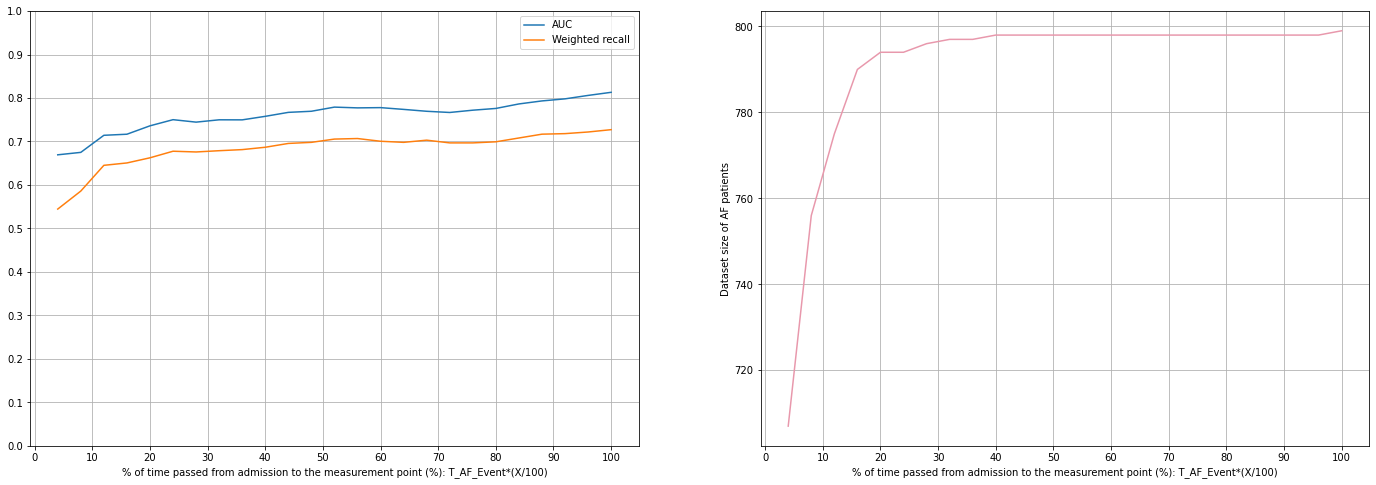

In [18]:
use_X_hours_after_admission = False #add absolute hours to admission time until the time exceeds or is equal to the prediction point
use_X_percentage_after_admission = True #make windows based on the percentage time already on ICU, with 100% the time to the prediction point, if false, substract absolute hours from measuredat

results = {"recall":np.array([])
            ,"mean_prob":np.array([])
            ,"precision":np.array([])
            ,"F1":np.array([])
            ,"mean_AF_prob":np.array([])
            ,"mean_noAF_prob":np.array([])
            ,"std_prob":np.array([])
            ,"AUC":np.array([])
            ,"MCC":np.array([])
            ,"dataset_size":np.array([])}

start_for_arange = 4 #if only_data_of_first_hours else 4
end_for_arange = 101 #201

for min_time_difference_to_AF in np.arange(start_for_arange,end_for_arange,4):

    if not use_X_hours_after_admission:
        if use_X_percentage_after_admission:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
            else:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_percent_time_after_admission.csv")
        else:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
            else:
                AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"_hours_before_prediction_point.csv")
    else:
        if one_half_hour_model:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_1_5_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")
        else:
            AF_dataset_false = pd.read_csv(data_string+"rot/AF_dataset_12_hours_risk_over_time_"+str(min_time_difference_to_AF)+"hours_after_adm.csv")

    AF_dataset_false.AF = AF_dataset_false.AF_orig
    
    AF_dataset_false["is_given_Magnesiumsulfaat (MgSO4)"]=0
    AF_dataset_false["is_given_LoopDiuretics"]=0
    if 'mean_Bumetanide (Burinex)' in AF_dataset_false.columns:
        AF_dataset_false.loc[(AF_dataset_false['mean_Bumetanide (Burinex)']>0) | (AF_dataset_false['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1
    AF_dataset_false['is_given_Propofol (Diprivan)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1
    AF_dataset_false['is_given_Dopamine (Inotropin)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

    test_AF_false_dataset = AF_dataset_false[(AF_dataset_false.admissionid.isin(test_admissionid))|(AF_dataset_false.date_corresponds_to_AF_admid.isin(test_admissionid))]
        
    X_test_false = test_AF_false_dataset[test_AF_false_dataset.columns.drop(drop_columns)][feature_columns]
    Y_test_false = test_AF_false_dataset.AF
    
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_false,label=Y_test_false), plot=False)

    results["recall"] = np.append(results["recall"],classification_report(Y_test_false,CB_AF.predict(X_test_false),target_names=["No-AF","AF"],output_dict=True,zero_division=0)['weighted avg']['recall'])
    results["precision"] = np.append(results["precision"],classification_report(Y_test_false,CB_AF.predict(X_test_false),target_names=["No-AF","AF"],output_dict=True,zero_division=0)['weighted avg']['precision'])
    results["F1"] = np.append(results["F1"],classification_report(Y_test_false,CB_AF.predict(X_test_false),target_names=["No-AF","AF"],output_dict=True,zero_division=0)['weighted avg']['f1-score'])
    results["mean_prob"] = np.append(results["mean_prob"],np.mean(CB_AF.predict_proba(X_test_false[feature_columns])[:,1]))
    results["mean_AF_prob"] = np.append(results["mean_AF_prob"],np.mean(CB_AF.predict_proba(X_test_false[test_AF_false_dataset.AF_orig==1][feature_columns])[:,1]))
    results["mean_noAF_prob"] = np.append(results["mean_noAF_prob"],np.mean(CB_AF.predict_proba(X_test_false[test_AF_false_dataset.AF_orig==0][feature_columns])[:,1]))
    results["std_prob"] = np.append(results["std_prob"],np.std(CB_AF.predict_proba(X_test_false[feature_columns])[:,1]))

    results["AUC"]=np.append(results["AUC"],auc(fpr,tpr))
    results["MCC"]=np.append(results["MCC"],matthews_corrcoef(Y_test_false,CB_AF.predict(X_test_false)))
    results["dataset_size"]=np.append(results["dataset_size"],len(X_test_false[feature_columns]))

print("")
print("Done!")

print("AF EVALUATION")
    

fig, axs = plt.subplots(1, 2,figsize=(24,8))

axs[0].plot(np.arange(start_for_arange,end_for_arange,4),results["AUC"],label="AUC")
axs[0].plot(np.arange(start_for_arange,end_for_arange,4),results["recall"],label="Weighted recall")
axs[0].legend()

if use_X_percentage_after_admission:
    axs[0].set_xlabel("% of time passed from admission to the measurement point (%): T_AF_Event*(X/100)")
else:
    if use_X_hours_after_admission:
        axs[0].set_xlabel("Hours after admission: X")
    else:
        axs[0].set_xlabel("Hours subtracted from AF event: T_AF_Event-X")

axs[0].set_ylim([0,1])
axs[0].set_yticks(np.arange(0,1.01,0.1))
axs[0].set_xticks(np.arange(0,end_for_arange,10))
axs[0].grid()

axs[1].plot(np.arange(start_for_arange,end_for_arange,4),results["dataset_size"],color="#e898ac",label="Mean classifier probability")
axs[1].set_ylabel("Dataset size of AF patients")

if use_X_percentage_after_admission:
    axs[1].set_xlabel("% of time passed from admission to the measurement point (%): T_AF_Event*(X/100)")
else:
    if use_X_hours_after_admission:
        axs[1].set_xlabel("Hours after admission: X")
    else:
        axs[1].set_xlabel("Hours subtracted from AF event: T_AF_Event-X")

axs[1].grid()
axs[1].set_xticks(np.arange(0,end_for_arange,10))
if present:
    axs[0].patch.set_alpha(0)
    axs[1].patch.set_alpha(0)

fig.show()


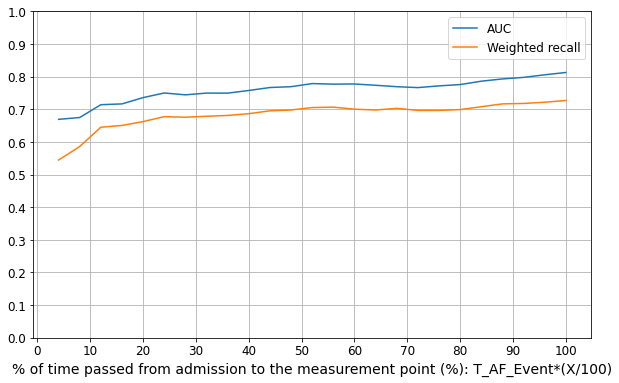

In [19]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(start_for_arange,end_for_arange,4),results["AUC"],label="AUC")
plt.plot(np.arange(start_for_arange,end_for_arange,4),results["recall"],label="Weighted recall")
plt.legend(fontsize=12)

if use_X_percentage_after_admission:
    plt.xlabel("% of time passed from admission to the measurement point (%): T_AF_Event*(X/100)",fontsize=14)
else:
    if use_X_hours_after_admission:
        plt.xlabel("Hours after admission: X")
    else:
        plt.xlabel("Hours subtracted from AF event: T_AF_Event-X")

plt.ylim([0,1])
plt.yticks(np.arange(0,1.01,0.1),fontsize=12)
plt.xticks(np.arange(0,end_for_arange,10),fontsize=12)
plt.grid()

plt.savefig("../results/figures/global_rot_eval.pdf")
plt.savefig("../results/figures/global_rot_eval.png")

plt.show()



# Data description features

In [31]:
rename_dict = {'mean_Lactaat (bloed)':'Mean lactate (mmol/L)',
'slope_Hartfrequentie':'Slope heart frequency (bpm)',
'max_Hartfrequentie':'Max heart frequency (bpm)',
'mean_UrineCAD':'Mean hourly urinary volume (mL/h)',
'min_UrineCAD':'Min hourly urinary volume (mL/h)',
'mean_O2-Saturatie (bloed)':'Mean calculated O2 saturation on ABG (%)',
'max_PO2 (bloed)':'Max ABG partial oxygen pressure (mmHg)',
'mean_O2 concentratie (Set)':'Mean ventilator administered FiO2 (%)',
'urgency':'ICU admission Urgency',
"min_Thrombo's (bloed)":'Min thrombocytes (10³/µL)',
'is_given_Noradrenaline (Norepinefrine)':'Has received noradrenalin',
'min_Ureum (bloed)':'Min blood ureum (mmol/L)',
'mean_Ureum (bloed)':'Mean blood ureum (mmol/L)',
'is_given_Furosemide (Lasix)':'Has received loop diuretics',
'min_Act.HCO3 (bloed)':'Min bicarbonate (mmol/L',
'mean_Act.HCO3 (bloed)':'Mean bicarbonate (mmol/L',
'Weight':'Weight (kg)',
'mean_PEEP (Set)':'Mean PEEP setting (mmHg)',
'fluid_balance':'Fluid Balance (mL)',
'mean_CVD':'Mean CVP (mmHg)',
'min_CVD':'Min CVP (mmHg)',
'max_CVD':'Man CVP (mmHg)',
'slope_ABP systolisch':'Slope systolic ABP (mmHg)',
'min_ABP systolisch':'Min systolic ABP (mmHg)',
'min_pH (bloed)':'Min arterial pH on blood gas',
'slope_ABP gemiddeld':'Slope mean ABP (mmHg)',
'min_ABP gemiddeld':'Min mean ABP (mmHg)',
'max_Fosfaat (bloed)':'Max Phosphate (mmol/L)',
'max_ABP systolisch':'Max systolic ABP (mmHg)',
'min_Lactaat (bloed)':'Min Lactate (mmol/L)',
'max_UrineCAD':'Max hourly urinary volume (mL/h)',
'mean_Hartfrequentie':'Mean heart frequency (bpm)',
'min_Fosfaat (bloed)':'Min Phosphate (mmol/L)',
'is_given_Propofol (Diprivan)':'Has received Propofol (Diprivan)',
"max_Thrombo's (bloed)":'Max thrombocytes (10³/µL)',
'slope_B.E. (bloed)':'Slope base excess (mmol/L)'}

X_train_descr = X_train.rename(columns=rename_dict)

if one_half_hour_model:
    describe_df_15_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_no_AF["text"]=describe_df_15_no_AF["mean"].astype(str) +' ('+describe_df_15_no_AF["25%"].astype(str) +" - " + describe_df_15_no_AF["75%"].astype(str) + ")"
    describe_df_15_no_AF = describe_df_15_no_AF[["text"]]
    describe_df_15_no_AF = describe_df_15_no_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_no_AF = describe_df_15_no_AF.rename_axis('Feature').reset_index()

    describe_df_15_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_AF["text"]=describe_df_15_AF["mean"].astype(str) +' ('+describe_df_15_AF["25%"].astype(str) +" - " + describe_df_15_AF["75%"].astype(str) + ")"
    describe_df_15_AF = describe_df_15_AF[["text"]]
    describe_df_15_AF = describe_df_15_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_AF = describe_df_15_AF.rename_axis('Feature').reset_index()

    nans_15_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-1.5_AF"]).rename_axis('Feature').reset_index()
    nans_15_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-1.5_noAF"]).rename_axis('Feature').reset_index()

    nans_15_df = nans_15_AF_df.copy(deep=True)
    nans_15_df["Model-1.5"] = nans_15_noAF_df["Model-1.5_noAF"].astype(str) + " - " +nans_15_AF_df["Model-1.5_AF"].astype(str)
    nans_15_df = nans_15_df[["Feature","Model-1.5"]]
    
    
elif six_hour_model:
    describe_df_6_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_no_AF["text"]=describe_df_6_no_AF["mean"].astype(str) +' ('+describe_df_6_no_AF["25%"].astype(str) +" - " + describe_df_6_no_AF["75%"].astype(str) + ")"
    describe_df_6_no_AF = describe_df_6_no_AF[["text"]]
    describe_df_6_no_AF = describe_df_6_no_AF.rename(columns={"text":"Model-6"})
    describe_df_6_no_AF = describe_df_6_no_AF.rename_axis('Feature').reset_index()

    describe_df_6_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_AF["text"]=describe_df_6_AF["mean"].astype(str) +' ('+describe_df_6_AF["25%"].astype(str) +" - " + describe_df_6_AF["75%"].astype(str) + ")"
    describe_df_6_AF = describe_df_6_AF[["text"]]
    describe_df_6_AF = describe_df_6_AF.rename(columns={"text":"Model-6"})
    describe_df_6_AF = describe_df_6_AF.rename_axis('Feature').reset_index()

    nans_6_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-6_AF"]).rename_axis('Feature').reset_index()
    nans_6_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-6_noAF"]).rename_axis('Feature').reset_index()

    nans_6_df = nans_6_AF_df.copy(deep=True)
    nans_6_df["Model-6"] = nans_6_noAF_df["Model-6_noAF"].astype(str) + " - " +nans_6_AF_df["Model-6_AF"].astype(str)
    nans_6_df = nans_6_df[["Feature","Model-6"]]

else:
    describe_df_12_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_no_AF["text"]=describe_df_12_no_AF["mean"].astype(str) +' ('+describe_df_12_no_AF["25%"].astype(str) +" - " + describe_df_12_no_AF["75%"].astype(str) + ")"
    describe_df_12_no_AF = describe_df_12_no_AF[["text"]]
    describe_df_12_no_AF = describe_df_12_no_AF.rename(columns={"text":"Model-12"})
    describe_df_12_no_AF = describe_df_12_no_AF.rename_axis('Feature').reset_index()

    describe_df_12_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_AF["text"]=describe_df_12_AF["mean"].astype(str) +' ('+describe_df_12_AF["25%"].astype(str) +" - " + describe_df_12_AF["75%"].astype(str) + ")"
    describe_df_12_AF = describe_df_12_AF[["text"]]
    describe_df_12_AF = describe_df_12_AF.rename(columns={"text":"Model-12"})
    describe_df_12_AF = describe_df_12_AF.rename_axis('Feature').reset_index()

    nans_12_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-12_AF"]).rename_axis('Feature').reset_index()
    nans_12_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-12_noAF"]).rename_axis('Feature').reset_index()

    nans_12_df = nans_12_AF_df.copy(deep=True)
    nans_12_df["Model-12"] = nans_12_noAF_df["Model-12_noAF"].astype(str) + " - " +nans_12_AF_df["Model-12_AF"].astype(str)
    nans_12_df = nans_12_df[["Feature","Model-12"]]


In [32]:
if len(describe_df_15_no_AF)*len(describe_df_6_no_AF)*len(describe_df_12_no_AF)>0:
    describe_df_15_AF.merge(describe_df_6_AF,on="Feature",how="outer").merge(describe_df_12_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_AF_amst.csv",index=False)
    describe_df_15_no_AF.merge(describe_df_6_no_AF,on="Feature",how="outer").merge(describe_df_12_no_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_no_AF_amst.csv",index=False)

In [32]:
if len(nans_15_df)*len(nans_6_df)*len(nans_12_df)>0:
    nans_15_df.merge(nans_6_df,on="Feature",how="outer").merge(nans_12_df,on="Feature",how="outer").to_csv("../results/nans_AMST.csv",index=False)